# Q learning vs Double Q-learning

In [1]:
# imports 
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"
import gym

from windy_gridworld import WindyGridworldEnv

In [2]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon=1, decay_rate=1):
        self.Q = Q
        self.epsilon = epsilon
        self.state_counts = np.ones(self.Q.shape[0])
        self.decay_rate = decay_rate
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs]))
        else:
            max_q = np.where(np.max(self.Q[obs]) == self.Q[obs])[0]
            action = np.random.choice(max_q)
        return action
    
    def update_epsilon(self):
        if self.epsilon > 0.05:
            self.epsilon *= self.decay_rate
    
class EpsilonGreedyPolicyDoubleQ(object):
    """
    A simple epsilon greedy policy, taking average over the two Q functions.
    Q [state, 2, action]
    """
    def __init__(self, Q, epsilon=1, decay_rate=1):
        self.Q = Q
        self.epsilon = epsilon
        self.state_counts = np.ones(self.Q.shape[0])
        self.decay_rate = decay_rate
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE  
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs, 0]))
        else:
            qtable_sum = self.Q[obs][0] + self.Q[obs][1]
            # Randomly break ties
            max_q = np.where(np.max(qtable_sum) == qtable_sum)[0]
            action = np.random.choice(max_q)
        return action
    
    def update_epsilon(self):
        if self.epsilon > 0.05:
            self.epsilon *= self.decay_rate

In [3]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [21]:
def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # convert tuple s to corresponding int if necessary
        if isinstance(s, tuple):
            int_s = 0
            temp = 1
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])
        if i_episode and not i_episode % 100:
            policy.update_epsilon()
        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            if done != True:
                Q[s, a] += alpha * (r + discount_factor * np.max(Q[s_new]) - Q[s, a])
            else:
                Q[s, a] += alpha * (r - Q[s, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)



In [22]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function [states, 2, actions]
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        if isinstance(s, tuple):
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])

        if i_episode and not i_episode % 100:
            policy.update_epsilon()
        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            # flip coin, choose Q function
            c = int(np.random.rand() < 0.5)
            max_a = np.argmax(Q[s_new, c])
            if done != True:
                Q[s, c, a] += alpha * (r + discount_factor * Q[s_new, (c-1)**2 , max_a] - Q[s, c, a])
            else:
                Q[s, c, a] += alpha * (r  - Q[s, c, a])
            
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


In [23]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

# Environments

In [24]:
# initialize envs and Q values
wind_env = WindyGridworldEnv()
Q_single_wind = np.zeros((wind_env.nS, wind_env.nA))
Q_double_wind = np.zeros((wind_env.nS, 2, wind_env.nA))

roul_env = gym.make('Roulette-v0')
Q_single_roul = np.zeros([roul_env.observation_space.n, roul_env.action_space.n])
Q_double_roul = np.zeros(([roul_env.observation_space.n, 2, roul_env.action_space.n]))

frozen_env = gym.make('FrozenLake-v0')
Q_single_frozen = np.zeros([frozen_env.observation_space.n, frozen_env.action_space.n])
Q_double_frozen = np.zeros(([frozen_env.observation_space.n, 2, frozen_env.action_space.n]))


## 1. Test a single run

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31054.68it/s]


Final performance Q-learning:  -1.451
Final performance double Q-learning:  0.027


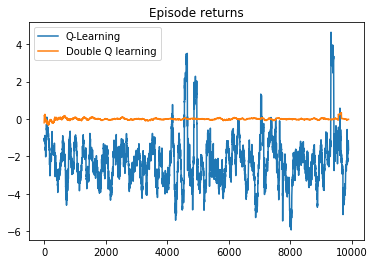

In [45]:
env = roul_env
Q_single = np.copy(Q_single_roul)
Q_double = np.copy(Q_double_roul)
epsilon = 0.8
decay_rate = 0.90
num_episodes = 10000
alpha=0.1

# single Q learning
policy_single = EpsilonGreedyPolicy(Q_single, epsilon=epsilon, decay_rate=decay_rate)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy_single, Q_single, num_episodes, alpha=alpha)
# double Q learning
policy_double = EpsilonGreedyPolicyDoubleQ(Q_double, epsilon=epsilon, decay_rate=decay_rate)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy_double, Q_double, num_episodes, alpha=alpha)

print("Final performance Q-learning: ", np.mean(episode_returns_q_learning[int(num_episodes * 0.9):]))
print("Final performance double Q-learning: ", np.mean(episode_returns_double_q_learning[int(num_episodes * 0.9):]))

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.show()

## 2. Run multiple seeds

In [37]:

def multiple_runs(env, Q, num_episodes, num_seeds, discount_factor=1, alpha=1, epsilon=1, decay_rate=1):
    returns = []
    lengths = []
    
    for i in range(num_seeds):
        np.random.seed(i)
        Q_init = np.copy(Q)
        if len(Q.shape) == 3:
            policy = EpsilonGreedyPolicyDoubleQ(Q_init, epsilon=epsilon, decay_rate=decay_rate)
            Q_trained, (episode_lengths, episode_returns) = double_q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        else:
            policy = EpsilonGreedyPolicy(Q_init, epsilon=epsilon, decay_rate=decay_rate)
            Q_trained, (episode_lengths, episode_returns) = q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        returns.append(episode_returns)
        lengths.append(episode_lengths)
    return np.array(lengths), np.array(returns)

def plot_mean_std(X, n, label):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    plt.plot(running_mean(mu, n), label=label)
    plt.fill_between(np.arange(len(running_mean(mu, n))), running_mean(mu+sigma, n), running_mean(mu-sigma, n), alpha=0.5)

            
        
    

In [48]:
env = roul_env
Q_single = np.copy(Q_single_roul)
Q_double = np.copy(Q_double_roul)

epsilons = [0.1, 0.3, 0.5, 0.7, 0.9]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
decay_rate = 0.9
num_episodes = 5000
num_seeds = 10

q_final_performances = {}
double_q_final_performances = {}
for epsilon in epsilons:
    for alpha in alphas: 
        single_q_lengths, single_q_returns = multiple_runs(env, Q_single, num_episodes, num_seeds, alpha=alpha, epsilon=epsilon, decay_rate=decay_rate)
        double_q_lengths, double_q_returns = multiple_runs(env, Q_double, num_episodes, num_seeds, alpha=alpha, epsilon=epsilon, decay_rate=decay_rate)
        q_final_performances[(epsilon, alpha)] = single_q_returns[:, int(num_episodes * 0.9):].mean()
        double_q_final_performances[(epsilon, alpha)] = double_q_returns[:, int(num_episodes * 0.9):].mean()
        



 47%|████████████████████████████████████▉                                         | 473/1000 [00:01<00:01, 472.05it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 23810.30it/s]


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 28555.99it/s]

In [50]:
q_epsilon, q_alpha = max(q_final_performances, key=q_final_performances.get)
d_q_epsilon, d_q_alpha = max(double_q_final_performances, key=double_q_final_performances.get)

print(f"best Q epsilon: {q_epsilon}, Q alpha: {q_alpha}")
print(f"best double Q epsilon: {d_q_epsilon}, Q alpha: {d_q_alpha}")

best Q epsilon: 0.1, Q alpha: 0.1
best double Q epsilon: 0.5, Q alpha: 0.3


In [ ]:
q_epsilon = 0.8
d_q_epsilon = 0.8
q_alpha = 0.8
d_q_alpha = 0.8
decay_rate = 0.9
num_episodes = 10000
num_seeds = 20
n = 100

single_q_lengths, single_q_returns = multiple_runs(env, Q_single, num_episodes, num_seeds, alpha=q_alpha, epsilon=q_epsilon, decay_rate=decay_rate)
double_q_lengths, double_q_returns = multiple_runs(env, Q_double, num_episodes, num_seeds, alpha=d_q_alpha, epsilon=d_q_epsilon, decay_rate=decay_rate)
        


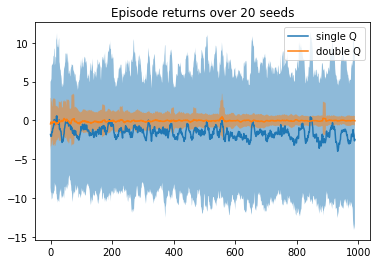

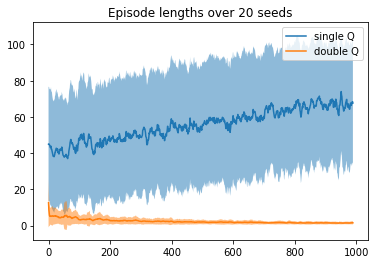

In [40]:
plt.title(f'Episode returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, n, "single Q")
plot_mean_std(double_q_returns, n, "double Q")
plt.legend()
plt.show()

plt.title(f'Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, n, "single Q")
plot_mean_std(double_q_lengths, n, "double Q")
plt.legend()
plt.show()